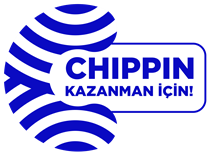

# Comprehensive Customer Value and Management Use Case  




In [2]:
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import kstest
import plotly.express as px
import plotly.graph_objects as go
import openpyxl
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import time 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier



SEED = 42
warnings.filterwarnings("ignore")



# Dataset

- The dataset is provided in 3 separate CSV files and contains 133,074 unique cb_customer_ids.
- The "best" dataset consists of 3 columns.
- The "gender" column is mostly labeled as "UNKNOWN".
- There are 130,536 null values in the date_of_birth column.
- The date_of_birth column contains incorrect birth dates (e.g., 2069, 2055).
- As seen in the pairplot() graph, the distributions of amount_after_discount, amount_before_discount, and amount_discount are similar (this can be clearly observed in the histogram).

In [41]:
best = pd.read_csv('./cust_best_sample.csv') 
cust = pd.read_csv('./cust_sample.csv') 
trx = pd.read_csv('./trx_sample.csv') 

In [42]:
best.info()
print(best.isnull().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133074 entries, 0 to 133073
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   unique_customer_id  133074 non-null  uint64
 1   gender              133074 non-null  object
 2   date_of_birth       2538 non-null    object
dtypes: object(2), uint64(1)
memory usage: 3.0+ MB
unique_customer_id         0
gender                     0
date_of_birth         130536
dtype: int64


In [43]:
best[best["date_of_birth"]> "2015-01-01"] 

,unique_customer_id,gender,date_of_birth
14,10760773275552365563,UNKNOWN,2069-08-14
520,7119492680593736990,UNKNOWN,2055-08-30
1294,17932542875492193526,UNKNOWN,2070-04-04
1579,12016634096935283071,UNKNOWN,2059-10-06
1810,14012553068184773835,UNKNOWN,2070-07-03
...,...,...,...
131298,3048551069142546515,UNKNOWN,2058-09-15
131993,16827578878166608146,UNKNOWN,2069-03-11
132014,2386529878023270049,UNKNOWN,2065-03-02
132756,13781583181726588381,UNKNOWN,2070-05-20


In [44]:
merged_trx = pd.merge(trx, cust, on='cb_customer_id', how='inner')
df = pd.merge(merged_trx, best, on='unique_customer_id', how='left')
df.drop_duplicates(inplace=True)
df_copy = df.copy()
df_copy.head()

,cb_customer_id,transaction_date,amount_after_discount,cb_branch_id,amount_before_discount,amount_discount,unique_customer_id,gender,date_of_birth
0,6821860387409851780,2016-07-26,-0.327119,90,-0.411608,-0.443104,14833856522183602191,UNKNOWN,NaN
1,6821860387409851780,2016-08-02,-0.327119,90,-0.411608,-0.443104,14833856522183602191,UNKNOWN,NaN
2,3372770238413923649,2016-06-20,-0.389015,26,-0.331083,-0.281383,219680563978627406,UNKNOWN,NaN
3,3220055865641973068,2016-06-15,-0.344771,90,-0.447712,-0.488551,13102778631438780637,UNKNOWN,NaN
4,1603206957613929399,2016-06-20,-1.139010,33,-1.580552,-1.771293,13698985552782800647,UNKNOWN,NaN


<AxesSubplot:xlabel='count', ylabel='gender'>

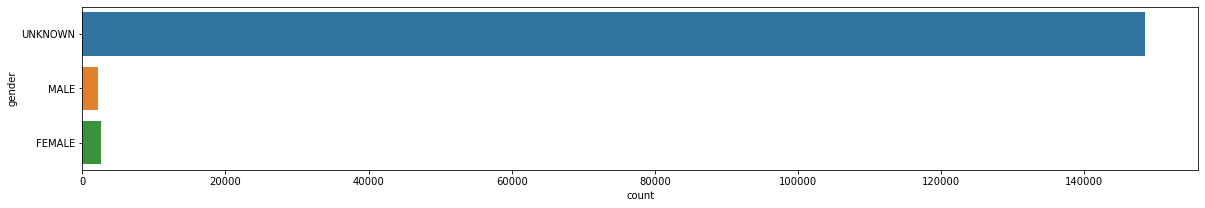

In [45]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y="gender", data=df_copy)

In [9]:
# UNKNOWN tanımlı satırları na olarak atadım.
df_copy['gender'] = df_copy['gender'].replace('UNKNOWN', np.nan)

# Data Exploration and Cleaning

In [10]:
print("#### Tanımlayıcı İstatistikler ###")
df_copy.describe()

#### Tanımlayıcı İstatistikler ###


,cb_customer_id,amount_after_discount,cb_branch_id,amount_before_discount,amount_discount,unique_customer_id
count,1.532130e+05,153213.000000,153213.000000,153213.000000,153213.000000,1.532130e+05
mean,9.219141e+18,-0.000059,59.743305,-0.000146,-0.000191,9.223710e+18
std,5.319024e+18,0.998698,30.441829,0.998532,0.998594,5.336933e+18
min,1.430848e+13,-10.317209,0.000000,-9.137788,-9.115476,2.885123e+14
25%,4.617722e+18,-0.344771,32.000000,-0.425285,-0.488551,4.580966e+18
50%,9.219466e+18,-0.132967,68.000000,-0.169028,-0.205634,9.233832e+18
75%,1.381950e+19,0.190905,90.000000,0.229723,0.267022,1.383845e+19
max,1.844656e+19,13.939131,93.000000,15.661321,16.521000,1.844670e+19


In [11]:
print("#### Veri Türleri ###")
print(df_copy .info())  

#### Veri Türleri ###
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153213 entries, 0 to 153531
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cb_customer_id          153213 non-null  uint64 
 1   transaction_date        153213 non-null  object 
 2   amount_after_discount   153213 non-null  float64
 3   cb_branch_id            153213 non-null  int64  
 4   amount_before_discount  153213 non-null  float64
 5   amount_discount         153213 non-null  float64
 6   unique_customer_id      153213 non-null  uint64 
 7   gender                  4748 non-null    object 
 8   date_of_birth           3296 non-null    object 
dtypes: float64(3), int64(1), object(3), uint64(2)
memory usage: 11.7+ MB
None


In [12]:
print("#### NULL değerler  ###")
print(df_copy.isnull().sum())  

#### NULL değerler  ###
cb_customer_id                 0
transaction_date               0
amount_after_discount          0
cb_branch_id                   0
amount_before_discount         0
amount_discount                0
unique_customer_id             0
gender                    148465
date_of_birth             149917
dtype: int64


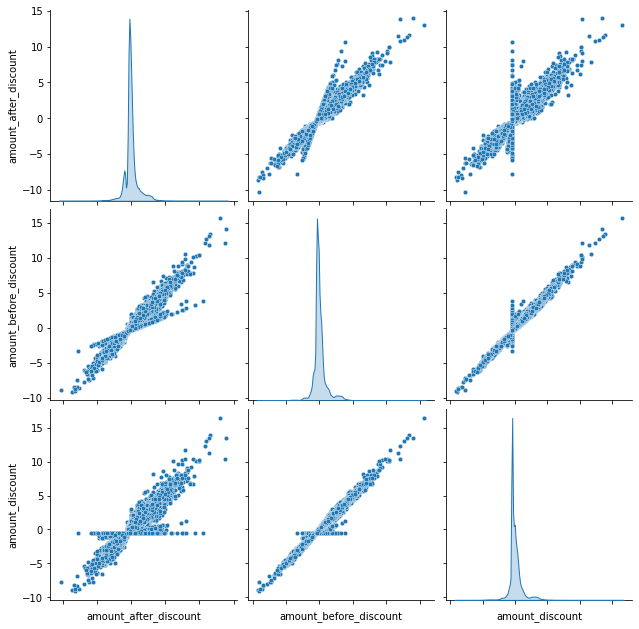

In [13]:
pp = sns.pairplot(df_copy[['amount_after_discount','amount_before_discount', 'amount_discount']], palette = 'deep', 
                  size=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[])

- The transaction_date and date_of_birth columns were assigned as datetime.
- It was found that 149,917 rows in the date_of_birth column are null.
- It was found that 148,465 rows in the gender column are null.
- The date_of_birth and gender columns were removed.

<AxesSubplot:>

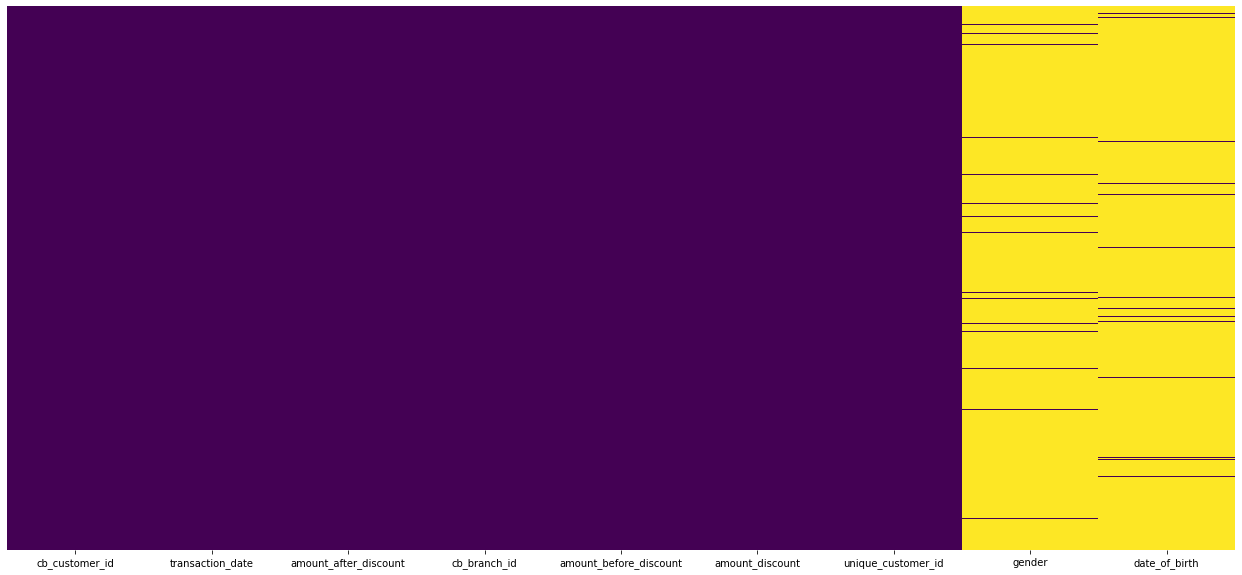

In [14]:

plt.figure(figsize=(22, 10))
sns.heatmap(df_copy.isnull(), yticklabels=False, cbar=False, cmap='viridis') 

In [15]:
# Data tipini tarih olarak düzeltim
df_copy['transaction_date'] = pd.to_datetime(df_copy['transaction_date'])
df_copy["date_of_birth"]= pd.to_datetime(df_copy["date_of_birth"])

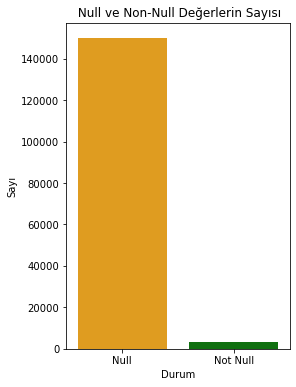

In [16]:
df['birtd_date_status'] = df['date_of_birth'].isnull().map({True: 'Null', False: 'Not Null'})
#date_of_birth'deki null olan ve olamyan değerleri görselleştirdim.
plt.figure(figsize=(4,6))
sns.countplot(x='birtd_date_status', data=df, palette={'Null': 'orange', 'Not Null': 'green'})
plt.xlabel("Durum")
plt.ylabel("Sayı")
plt.title(" Null ve Non-Null Değerlerin Sayısı")
plt.show()

In [17]:
df_copy.drop(columns=['date_of_birth',"gender"], inplace=True)


# Feature Engineering

- I computed the distinct number of branches visited per customer and assigned it to the branch_count column.
- I calculated the total discount per customer and assigned it to the discount_sum column.
- I determined the Monetary_beforeDis variable by summing the pre-discount expenditures per customer.
- I built an RFM framework to calculate the Recency, Frequency, and Monetary values.
- Then, based on the Recency and Frequency scores, I assigned an RF score to each customer.
- Finally, I categorized these scores into groups such as Churn, at_risk, and loyal_customers.

In [18]:
# uğradıkları şube sayısının eklenmesi:
df_copy['branch_count'] = df_copy.groupby('unique_customer_id')['cb_branch_id'].transform('nunique')
# indirimlerin toplanması
df_copy['discount_sum'] = df_copy.groupby('unique_customer_id')['amount_discount'].transform('sum')
# indirim öncesi harcamalarının toplanması
df_copy['Monetary_beforeDis'] = df_copy.groupby('unique_customer_id')['amount_before_discount'].transform('sum')

## RFM 


- According to the generated RF segment, for the Churn segment:
   - The average Recency value is 130 days.
   - The average Frequency value is 1.08.
   - The average Monetary value is 0.10.


In [19]:
# Datasetindeki maksimum tarihi almak için yaptım.
max_date = df_copy['transaction_date'].max() 

# Recency icin;
rfm_data = df_copy.groupby('unique_customer_id').agg({
    'transaction_date': lambda x: x.max(), 
})

rfm_data['Recency'] = (max_date - rfm_data['transaction_date']).dt.days
rfm_data.drop(columns='transaction_date', inplace=True)

# Frequency icin:
freq_data = df_copy.groupby('unique_customer_id').agg({
    'transaction_date': 'count'
}).rename(columns={'transaction_date': 'Frequency'})

# Monetary icin:
mon_data = df_copy.groupby('unique_customer_id').agg({
    'amount_after_discount': 'sum'
}).rename(columns={'amount_after_discount': 'Monetary'})

# Joinleme
rfm = rfm_data.join(freq_data).join(mon_data)

##### Skorları Atamak İcin;
## Recency Skoru icin;
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
## Frequency Skoru İcin;
bins = [0, 1, 2, 3, 5, np.inf]
labels = [1, 2, 3, 4, 5]
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=bins, labels=labels)
## Monetary Skoru İcin;
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

## Skorların birlestirilmesi
rfm['RF_Score'] = rfm['R_Score'].astype(str) + \
                   rfm['F_Score'].astype(str) 

## Skorlara uydun segmentleri atamak icin;
seg_map = {
    r'[1-2][1-2]': 'Churn',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['RF_segment'] = rfm['RF_Score'].replace(seg_map, regex=True)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,RF_segment
unique_customer_id,,,,,,,,
288512277526182,91,3,0.631865,4,3,5,43,potential_loyalists
442982885829789,80,1,-0.380075,4,1,2,41,promising
494952537561067,74,2,-1.219022,4,2,1,42,potential_loyalists
619564307179957,32,1,0.277410,5,1,4,51,new_customers
644980618238310,107,1,2.564931,3,1,5,31,about_to_sleep


In [20]:
## Segmentlere göre sayı ve ortalamalara bakmak icin;
rfm.groupby("RF_segment").agg({"Recency": "mean",
                            "Frequency": "mean",
                            "Monetary": ["mean","count"]})

Recency Frequency  Monetary       
                           mean      mean      mean  count
RF_segment                                                
Churn                130.626196  1.083863  0.109947  51000
about_to_sleep       101.602714  1.107197  0.092080  25206
at_Risk              128.235919  3.196599 -0.777250    941
cant_loose           123.500000  7.909091 -2.770088     22
champions             22.198718  6.858974 -1.345816    156
loyal_customers       91.668192  4.693364 -0.928401    437
need_attention       101.637255  3.000000 -0.482807    612
new_customers         30.789552  1.000000 -0.159222  24063
potential_loyalists   58.997075  2.168183 -0.480716   6154
promising             84.035208  1.000000  0.022703  24483

In [21]:
# rfm ve df_copy birleştirmek icin;
data = pd.merge(df_copy, rfm, on='unique_customer_id', how='left')


In [22]:
# Modellerde denemek icin ürettigim diger degiskenler
data['avg_amount_spent'] = data['Monetary'] / data['Frequency']
data['avg_discount'] = data['discount_sum'] / data['Frequency']
data["discount_rate"] = data['discount_sum'] / data['Monetary_beforeDis']
data["discount_per_branch"]  =  data['discount_sum']/  data['branch_count']
data["Monetary_branch"]  =  data['discount_sum']/  data['branch_count']
data['branch_discount_interaction'] = data['branch_count'] * data['discount_rate']
data['spend_ratio'] = data['Monetary'] / data['Monetary_beforeDis']
data['discount_impact'] = 1 - data['spend_ratio']

# Distribution of data - Correlation Analysis

- A Kolmogorov-Smirnov normality test was performed to check whether the data follows a normal distribution.
- It was observed that the columns do not follow a normal distribution.
- Since the data is not normally distributed, a Spearman correlation test was conducted.
- Strong correlations were observed among some of the created variables.

In [23]:
colum_in = ['amount_after_discount','amount_before_discount', 'amount_discount','discount_sum',  'Monetary_beforeDis', 'Monetary', 'avg_amount_spent', 'avg_discount',"discount_per_branch", "discount_rate","Monetary_branch",'branch_discount_interaction','spend_ratio','discount_impact']
# Kolmogorov-Smirnov 
for column in colum_in:
    stat, p = kstest(data[column], 'norm')
    print(f"{column} için Kolmogorov-Smirnov Testi: Test İstatistiği = {stat}, p-değeri = {p}")
    if p > 0.05:
        print(f"{column}: Normal dağılıma uygun.")
    else:
        print(f"{column}: Normal dağılıma uygun değil.")

amount_after_discount için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.17792512606255673, p-değeri = 0.0
amount_after_discount: Normal dağılıma uygun değil.
amount_before_discount için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.1667549947435718, p-değeri = 0.0
amount_before_discount: Normal dağılıma uygun değil.
amount_discount için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.2124316853493105, p-değeri = 0.0
amount_discount: Normal dağılıma uygun değil.
discount_sum için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.15569759224294744, p-değeri = 0.0
discount_sum: Normal dağılıma uygun değil.
Monetary_beforeDis için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.17056352054330737, p-değeri = 0.0
Monetary_beforeDis: Normal dağılıma uygun değil.
Monetary için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.18535669002132593, p-değeri = 0.0
Monetary: Normal dağılıma uygun değil.
avg_amount_spent için Kolmogorov-Smirnov Testi: Test İstatistiği = 0.19418353755505413, p-değeri = 0.0

sns.set()
sns.pairplot(data[colum_in], size = 2.5)
plt.show()

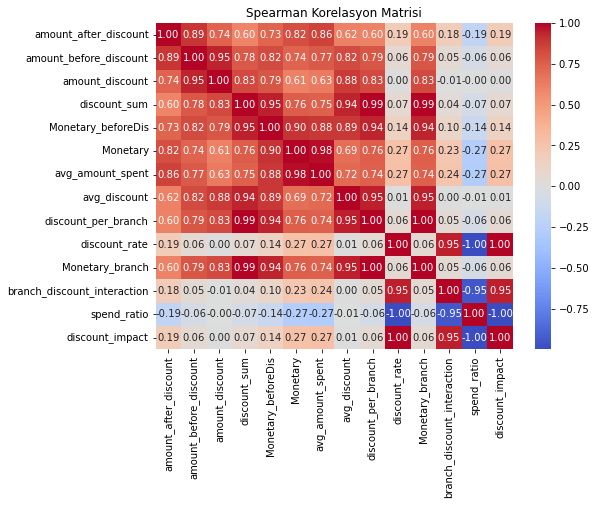

In [24]:
# Sürekli değişkenlerin seçimi ve korelasyon testi icin;
spearman_corr = data[colum_in].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Korelasyon Matrisi")
plt.show()

# Churn Model

- Since the dataset provided for the churn model does not include any churn label, the churn segment created using the RF score was selected as the target variable.
- Subsequently, the usable variables were chosen. (Note: Recency and Frequency will be used only for CLV prediction and will not be included in the churn - model to prevent data leakage.)
- The dataset exhibits a slight imbalance.
- One of the variables intended for use as an explanatory variable, discount_sum, has been scaled. Since the scaling information is unknown, I focused on tree-based models that are least affected by scaling, are more robust to outliers, and do not suffer from multicollinearity issues.
- As success metrics, due to the slight imbalance in the dataset, both F1 macro (which gives more weight to the minority class) and Accuracy were observed.
- The best model turned out to be an XGBoost model, achieving 0.71 Accuracy and 0.69 F1 Macro score.
- Hyperparameter optimization was attempted, but it did not improve the score.
- According to the SAHP analysis, the most important variables influencing the model's predictions are Monetary_beforeDis and discount_impact

In [25]:
# RF segmentindeki Churn olanlar  hedef değişkene atanmıştır. 
data['churn_flag'] = np.where(data['RF_segment'] == "Churn", 1, 0)

# Gereksiz kolonları atmak için.
data_new = data[['branch_count','discount_sum',  'Recency','Frequency', ## Recency ve Frequecy CLV predictionda kullanılacaktır.
                  "unique_customer_id", "discount_rate","discount_per_branch",
                  'Monetary_beforeDis','Monetary','avg_amount_spent','avg_discount', 'churn_flag',
                    "Monetary_branch", 'branch_discount_interaction','spend_ratio','discount_impact']]
data_new.drop_duplicates(inplace=True)

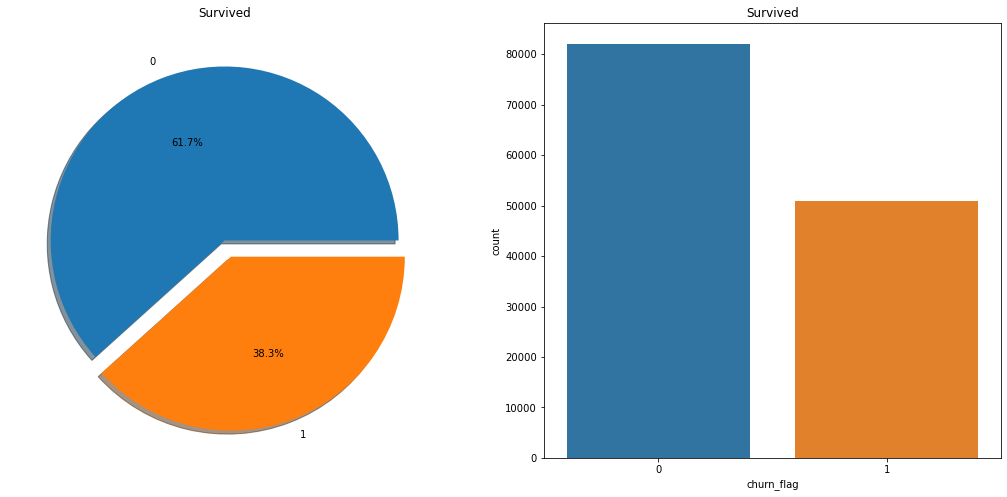

In [26]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data_new['churn_flag'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
#sns.countplot('churn_flag',data_new,ax=ax[1])
sns.countplot(x='churn_flag', data=data_new, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In [27]:
data_new.head()

,branch_count,discount_sum,Recency,Frequency,unique_customer_id,discount_rate,discount_per_branch,Monetary_beforeDis,Monetary,avg_amount_spent,avg_discount,churn_flag,Monetary_branch,branch_discount_interaction,spend_ratio,discount_impact
0,1,-0.886209,45,2,14833856522183602191,1.076519,-0.886209,-0.823217,-0.654238,-0.327119,-0.443104,0,-0.886209,1.076519,0.794733,0.205267
2,1,-0.281383,88,1,219680563978627406,0.849886,-0.281383,-0.331083,-0.389015,-0.389015,-0.281383,0,-0.281383,0.849886,1.174978,-0.174978
3,1,-0.488551,93,1,13102778631438780637,1.091217,-0.488551,-0.447712,-0.344771,-0.344771,-0.488551,0,-0.488551,1.091217,0.770073,0.229927
4,1,-4.519687,85,4,13698985552782800647,1.060934,-4.519687,-4.260102,-3.497043,-0.874261,-1.129922,0,-4.519687,1.060934,0.820882,0.179118
8,1,-0.092018,127,1,8221697626171255583,0.741746,-0.092018,-0.124056,-0.168271,-0.168271,-0.092018,1,-0.092018,0.741746,1.356414,-0.356414


In [28]:
# recency ve frequency data sızıntısı olmaması için çıkarılmıştır.

x = data_new[[  'branch_count', 'Monetary_beforeDis', 'avg_discount',   'discount_impact']]

y = data_new[['churn_flag']]

#x.drop_duplicates(inplace=True)

# Test-Train;

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, stratify=y, 
    shuffle=True
)

print("Train set sınıf dağılımı:\n", y_train.value_counts())
print("\nTest set sınıf dağılımı:\n", y_test.value_counts())


Train set sınıf dağılımı:
 churn_flag
0             65659
1             40800
dtype: int64

Test set sınıf dağılımı:
 churn_flag
0             16415
1             10200
dtype: int64


In [30]:
Train_val = pd.concat([x_train,  y_train], axis=1)
val =  pd.concat([x_test,  y_test], axis=1)

In [58]:
model = XGBClassifier(random_state=42)
model.fit(x_train,  y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Seti Doğruluk Skoru:", accuracy)
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Test Seti Doğruluk Skoru: 0.7054292692090927

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     16415
           1       0.62      0.59      0.61     10200

    accuracy                           0.71     26615
   macro avg       0.69      0.68      0.69     26615
weighted avg       0.70      0.71      0.70     26615



# Models

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=SEED)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('AdaBoost', AdaBoostClassifier(random_state=SEED)),
    ('Decision Tree', DecisionTreeClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED)),
    ('XGBClassifier', XGBClassifier(random_state=SEED))
    


]

scalers = [
    ('Standard Scaler', StandardScaler()),
    ('MinMax Scaler', MinMaxScaler()),
    ('Robust Scaler', RobustScaler())
]

results = []


for scaler_name, scaler in scalers:
    for classifier_name, classifier in classifiers:
        pipeline = Pipeline([
            ('scaler', scaler),  
            ('model', classifier)  
        ])
        
        pipeline.fit(x_train,  y_train)    
        
  
        y_pred = pipeline.predict(x_test)
        
   
        accuracy = accuracy_score(y_test, y_pred)
        results.append((scaler_name, classifier_name, accuracy))
        
        print(f"Scaler: {scaler_name}, Model: {classifier_name}")
        print(f"Doğruluk Skoru: {accuracy:.4f}")
        print("\nSınıflandırma Raporu:")
        print(classification_report(y_test, y_pred))
        print("="*50)

print("\nScaler ve Model Performans Karşılaştırması:")
for scaler_name, classifier_name, accuracy in results:
    print(f"Scaler: {scaler_name}, Model: {classifier_name}, Accuracy: {accuracy:.4f}")

Scaler: Standard Scaler, Model: Random Forest
Doğruluk Skoru: 0.7064

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     16415
           1       0.63      0.57      0.60     10200

    accuracy                           0.71     26615
   macro avg       0.69      0.68      0.68     26615
weighted avg       0.70      0.71      0.70     26615

Scaler: Standard Scaler, Model: Gradient Boosting
Doğruluk Skoru: 0.6780

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     16415
           1       0.59      0.50      0.54     10200

    accuracy                           0.68     26615
   macro avg       0.66      0.64      0.65     26615
weighted avg       0.67      0.68      0.67     26615

Scaler: Standard Scaler, Model: AdaBoost
Doğruluk Skoru: 0.6628

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0    

# Hyperparameter Optimization
## XGBClassifier

In [190]:
# Hiperparametre optimizasyonu


pipeline = Pipeline([
  #  ('scaler', MinMaxScaler()),  
    ('model', XGBClassifier(random_state=SEED))
])

param_grid = {
   # 'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7, -1],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [20, 31, 40],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',   # 
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train,  y_train)

print("En İyi Hiperparametreler:", grid_search.best_params_)
print("En İyi CV Skoru (F1-macro):", grid_search.best_score_)


y_pred = grid_search.best_estimator_.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Seti Doğruluk Skoru:", accuracy)

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
En İyi Hiperparametreler: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__num_leaves': 20, 'model__subsample': 0.8}
En İyi CV Skoru (F1-macro): 0.6836193383432192
Test Seti Doğruluk Skoru: 0.7080969378170204

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     16415
           1       0.62      0.60      0.61     10200

    accuracy                           0.71     26615
   macro avg       0.69      0.69      0.69     26615
weighted avg       0.71      0.71      0.71     26615



## Random Forest

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,            # Kaç farklı parametre kombinasyonu denenecek
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(x_train, y_train)

print("En iyi parametreler: ", random_search.best_params_)
print("En iyi CV skoru: ", random_search.best_score_)

best_rf = random_search.best_estimator_
test_score = best_rf.score(x_test, y_test)
print("Test seti skoru: ", test_score)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
En iyi parametreler:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 395}
En iyi CV skoru:  0.6922042532042791
Test seti skoru:  0.7118917903437911


## Importance of Variables


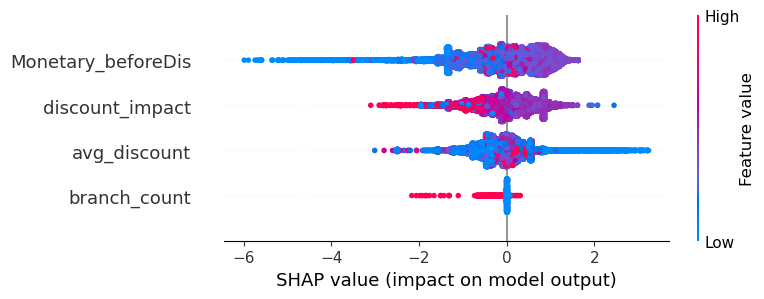

In [64]:

explainer = shap.Explainer(model)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test)


# CLV Prediction

- In the CLV Prediction study, the monetary variable will be predicted using regression analysis.
- The monetary variable is defined as the sum of individuals' amount_after_discount values.
- No variable derived from the monetary and amount_after_discount variables has been used as an explanatory variable (x).
- Due to the possibility that the monetary variable is scaled, the success metric was chosen as the Adjusted R².

### Variables
- CLV (Target): Defined as the total of customers' past transactions. In other words, each customer's total spending (the sum of amount_after_discount) will be used as the CLV.
- Recency: The number of days between the maximum date in the dataset and the customer's last transaction date.
- Frequency: The total number of transactions made by the customer.
- discount_sum: The total discount amount.
- Branch Count (branch_count): The number of different branches from which the customer has made transactions.

In [31]:
CLD = data_new.copy()

In [32]:
CLD["CLV"]  = CLD['Monetary']
CLD.drop_duplicates(inplace=True)

In [33]:
features = [ "Recency",'Frequency', 'branch_count','discount_sum'] #,'discount_sum'] #,'discount_per_branch' , 'avg_discount', 

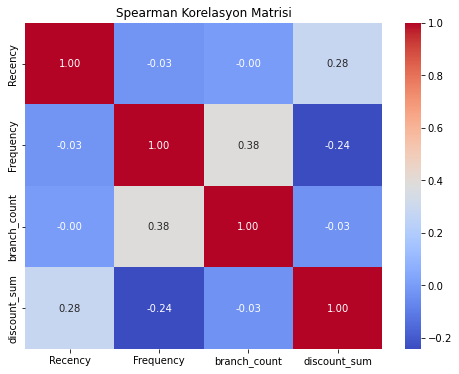

In [34]:
spearman_corr = CLD[features].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Korelasyon Matrisi")
plt.show()

In [35]:
x = CLD[features]
y = CLD["CLV"]

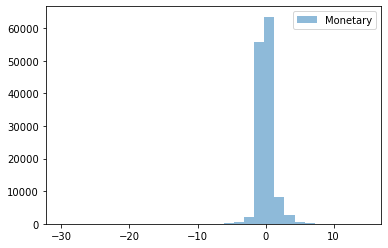

In [36]:
# data_new.columns
plt.hist(y, bins=30, alpha=0.5, label="Monetary")
plt.legend()
plt.show()

In [37]:
# Test-Train ayrımı;
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED ,
    shuffle=True
)

In [38]:

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(x_train, y_train)


y_pred = rf_reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Adjusted R² hesaplanması:
n = len(y_test)               # Test setindeki örnek sayısı
p = x_test.shape[1]    # Kullanılan özellik sayısı
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Test RMSE:", rmse)
print("Test R^2 Score:", r2)
print("Test Adjusted R^2 Score:", adjusted_r2)


Test RMSE: 0.43112452442447136
Test R^2 Score: 0.8201126204711929
Test Adjusted R^2 Score: 0.8200855799030563


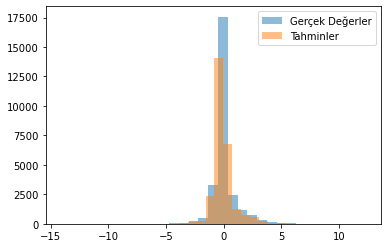

In [39]:
plt.hist(y_test, bins=30, alpha=0.5, label="Gerçek Değerler")
plt.hist(y_pred, bins=30, alpha=0.5, label="Tahminler")
plt.legend()
plt.show()

In [40]:

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "LGBMRegressor": LGBMRegressor( random_state=42),
    "XGBRegressor": XGBRegressor()
}

results = [] 

for name, model in models.items():

    model.fit(x_train, y_train)
    

    y_pred = model.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R² hesaplanması:
    n = len(y_test)                # Test setindeki örnek sayısı
    p = x_test.shape[1]     # Kullanılan özellik sayısı
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adjusted_r2
    })


print("Modellerin Performans Sonuçları:")
for res in results:
    print(f"{res['Model']}: RMSE = {res['RMSE']:.4f}, R² = {res['R2']:.4f}, Adjusted R² = {res['Adjusted R2']:.4f}")


best_model = max(results, key=lambda x: x["Adjusted R2"])
print(f"\nEn iyi model: {best_model['Model']} (Adjusted R²: {best_model['Adjusted R2']:.4f})")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 106459, number of used features: 4
[LightGBM] [Info] Start training from score 0.001565
Modellerin Performans Sonuçları:
Linear Regression: RMSE = 0.5101, R² = 0.7482, Adjusted R² = 0.7481
Random Forest: RMSE = 0.4311, R² = 0.8201, Adjusted R² = 0.8201
Gradient Boosting: RMSE = 0.4541, R² = 0.8005, Adjusted R² = 0.8004
Decision Tree: RMSE = 0.4932, R² = 0.7646, Adjusted R² = 0.7646
AdaBoost: RMSE = 0.5922, R² = 0.6606, Adjusted R² = 0.6605
LGBMRegressor: RMSE = 0.4500, R² = 0.8040, Adjusted R² = 0.8040
XGBRegressor: RMSE = 0.4537, R² = 0.8007, Adjusted R² = 0.8007

En iyi model: Random Forest (Adjusted R²: 0.8201)


# Hyperparameter Optimization

In [57]:

param_dist = {
    "n_estimators": randint(50, 300),  # Ağaç sayısı (50-300 arasında)
    "max_depth": randint(5, 50),  # Maksimum derinlik (5-50 arasında)
    "min_samples_split": randint(2, 20),  # Bir dalın bölünebilmesi için minimum örnek sayısı
    "min_samples_leaf": randint(1, 10),  # Minimum yaprak büyüklüğü
    "max_features": ["auto", "sqrt", "log2"],  # Özellik seçimi
}

rf_reg = RandomForestRegressor(random_state=42)


random_search = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist, 
    n_iter=50, scoring="r2", cv=5, verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(x_train, y_train)


print("En İyi Hiperparametreler:", random_search.best_params_)

best_rf_reg = random_search.best_estimator_

y_pred = best_rf_reg.predict(x_test)

# RMSE, R² ve Adjusted R² hesapla
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n, p = x_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Optimized Test RMSE:", rmse)
print("Optimized Test R² Score:", r2)
print("Optimized Test Adjusted R² Score:", adjusted_r2)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
En İyi Hiperparametreler: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 290}
Optimized Test RMSE: 0.4278324491233473
Optimized Test R² Score: 0.8228493785521189
Optimized Test Adjusted R² Score: 0.8228227493718938
